In [2]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [3]:
# CONSTANTS

base_log_dir = Path("../../yaib_logs")
model = "LogisticRegression"

map_race = {0: 'asian', 
            1: 'black',
            2: 'other',
            3: 'white'}

map_gender = {0: 'Female', 1: 'Male'}

map_attribute = {'race0': 'asian',
                 'race1': 'black',
                 'race2': 'other',
                 'race3': 'white',
                 'gender0': 'Female',
                 'gender1': 'Male'}

hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
hospital_dict = {} 
hospital_data = {}

for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    hospital_data[hospital_ids[i]] = {}

#### Summarize Race and Gender Subgroup AUCs

In [4]:
dist_shift_avg = np.load(f"../results/dist_shift/{model}-avg.npz") 
auc_metrics = [metric for metric in dist_shift_avg.files if re.compile(r'.*AUC.*').match(metric)]

for i in range(len(hospital_ids)):
    hospital_data[hospital_ids[i]]["AUC"] = dist_shift_avg["AUC"][i, i]
    
    for attribute in ["gender", "race"]:
        min_auc = float('inf')
        min_metric = None
        
        attribute_metrics = [metric for metric in auc_metrics if attribute in metric]
        for metric in attribute_metrics:
            auc_value = dist_shift_avg[metric][i, i]
            if auc_value < min_auc:
                min_auc = auc_value
                min_metric = metric
            hospital_data[hospital_ids[i]][f"{map_attribute[metric.split('_')[0]]}_auc"] = auc_value
        
        hospital_data[hospital_ids[i]][f"worst_{attribute}_subgroup"] = map_attribute[min_metric.split("_")[0]]

In [5]:
df = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df = df.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df = df.rename(columns={'hospitalid': 'hosp_id'})

In [6]:
# Create a new dataframe df1 grouped by hosp_id
df1 = df.groupby('hosp_id').agg(
    count=('stay_id', 'count'),
    white_count=('ethnic', lambda x: (x == 'white').sum()),
    black_count=('ethnic', lambda x: (x == 'black').sum()),
    other_count=('ethnic', lambda x: (x == 'other').sum()),
    asian_count=('ethnic', lambda x: (x == 'asian').sum())
)

# Calculate base rates for each ethnic group
total_counts = df1['white_count'] + df1['black_count'] + df1['other_count'] + df1['asian_count']
df1['white_rate'] = df1['white_count'] / total_counts
df1['black_rate'] = df1['black_count'] / total_counts
df1['other_rate'] = df1['other_count'] / total_counts
df1['asian_rate'] = df1['asian_count'] / total_counts

# Calculate counts for each gender
df1['male_count'] = df.groupby('hosp_id')['sex'].apply(lambda x: (x == 'Male').sum())
df1['female_count'] = df.groupby('hosp_id')['sex'].apply(lambda x: (x == 'Female').sum())

# Calculate rates for each gender
df1['male_rate'] = df1['male_count'] / df1['count']
df1['female_rate'] = df1['female_count'] / df1['count']

# Filter df1 to keep only hosp_ids in hospital_ids
df1 = df1[df1.index.isin(hospital_ids)]
df1 = df1.reset_index()
df1['hosp_id'] = df1['hosp_id'].astype(int)

# Sort the dataframe based on the order in hospital_ids
df1 = df1.set_index('hosp_id').loc[hospital_ids].reset_index()


In [7]:
# Add data from hospital_data to df1
for hosp_id, data in hospital_data.items():
    for key, value in data.items():
        df1.loc[df1['hosp_id'] == hosp_id, key] = value
        
df1 = df1.round(4)  # Round to 4 decimal places for readability

In [8]:
# Define general columns
general_columns = ['hosp_id', 'count', 'AUC']

# Define race-specific columns
race_columns = ['white_count', 'black_count', 'other_count', 'asian_count',
                'white_rate', 'black_rate', 'other_rate', 'asian_rate',
                'white_auc', 'black_auc', 'other_auc', 'asian_auc', 'worst_race_subgroup']

# Define gender-specific columns
gender_columns = ['male_count', 'female_count', 'male_rate', 'female_rate', 'Male_auc', 'Female_auc', 'worst_gender_subgroup']

# Create df_race
df_race = df1[general_columns + race_columns].copy()

# Create df_gender
df_gender = df1[general_columns + gender_columns].copy()

# Sort df_race and df_gender by hospital_id
df_race = df_race.sort_values('hosp_id')
df_gender = df_gender.sort_values('hosp_id')

In [9]:
df_race

,hosp_id,count,AUC,white_count,black_count,other_count,asian_count,white_rate,black_rate,other_rate,asian_rate,white_auc,black_auc,other_auc,asian_auc,worst_race_subgroup
0,73,4320,0.7609,3221,622,347,61,0.7577,0.1463,0.0816,0.0143,0.7085,0.8535,0.8824,1.0000,white
11,167,2107,0.7611,1503,154,421,29,0.7133,0.0731,0.1998,0.0138,0.7487,0.7655,0.8089,0.8214,white
9,188,2299,0.8015,1689,517,64,29,0.7347,0.2249,0.0278,0.0126,0.7976,0.8279,0.8108,0.9438,white
6,199,2529,0.8489,2434,42,48,3,0.9632,0.0166,0.0190,0.0012,0.8454,1.0000,0.8646,0.0000,asian
3,243,2812,0.7453,1831,873,83,24,0.6514,0.3106,0.0295,0.0085,0.7113,0.7899,0.9692,0.0000,asian
10,252,2210,0.7196,1993,152,50,7,0.9051,0.0690,0.0227,0.0032,0.7142,0.7222,0.8691,0.9000,white
1,264,3745,0.7266,3299,263,64,31,0.9021,0.0719,0.0175,0.0085,0.7268,0.6336,0.9535,1.0000,black
8,300,2370,0.8258,2000,267,84,19,0.8439,0.1127,0.0354,0.0080,0.8245,0.7931,0.8803,1.0000,black
4,338,2762,0.7578,2568,41,143,5,0.9314,0.0149,0.0519,0.0018,0.7693,1.0000,0.5815,0.0000,asian
2,420,3425,0.7840,2940,157,276,52,0.8584,0.0458,0.0806,0.0152,0.7694,0.9650,0.8559,0.9457,white


In [10]:
df_gender

,hosp_id,count,AUC,male_count,female_count,male_rate,female_rate,Male_auc,Female_auc,worst_gender_subgroup
0,73,4320,0.7609,2379,1941,0.5507,0.4493,0.7497,0.8024,Male
11,167,2107,0.7611,1185,922,0.5624,0.4376,0.7884,0.7258,Female
9,188,2299,0.8015,1231,1068,0.5355,0.4645,0.8332,0.7579,Female
6,199,2529,0.8489,1426,1102,0.5639,0.4357,0.8584,0.8452,Female
3,243,2812,0.7453,1566,1245,0.5569,0.4427,0.7402,0.7697,Male
10,252,2210,0.7196,1243,967,0.5624,0.4376,0.7035,0.7427,Male
1,264,3745,0.7266,1949,1796,0.5204,0.4796,0.7237,0.7359,Male
8,300,2370,0.8258,1274,1096,0.5376,0.4624,0.8176,0.8402,Male
4,338,2762,0.7578,1544,1218,0.5590,0.4410,0.7728,0.7320,Female
2,420,3425,0.7840,1988,1435,0.5804,0.4190,0.7976,0.7628,Female


#### Subgroup AUCs in Data Addition Settings

In [11]:
add_data_avg = np.load(f"../results/add_data/{model}-avg.npz")
add_data_std = np.load(f"../results/add_data/{model}-std.npz")
add_data_ci = np.load(f"../results/add_data/{model}-ci.npz")
add_subgroup_avg = np.load(f"../results/add_subgroup/{model}-avg.npz")

auc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*AUC.*').match(metric)]

base_columns = ['hosp_id', 'count', 'AUC']

In [12]:
hospital_aucs = np.array([hospital_data[hosp_id]['AUC'] for hosp_id in hospital_ids])

addition_data = {}
subgroup_addition_data = {}

for subgroup in auc_metrics:
    subgroup_data = add_data_avg[subgroup]
    subgroup_only_data = add_subgroup_avg[subgroup]

    subgroup_data = np.where(subgroup_data == 0, np.nan, subgroup_data)
    subgroup_only_data = np.where(subgroup_only_data == 0, np.nan, subgroup_only_data)
    
    if subgroup == "AUC_TEST":
        continue
    
    hospital_subgroup_aucs = dist_shift_avg[subgroup].diagonal()
    
    for i, auc_value in enumerate(hospital_subgroup_aucs):
        if auc_value == 0:
            subgroup_data[:, i] = np.nan
            subgroup_only_data[:, i] = np.nan
    
    if subgroup.split('_')[0] == 'AUC':
        addition_data['AUC'] = subgroup_data - hospital_subgroup_aucs
        subgroup_addition_data['AUC'] = subgroup_only_data - hospital_subgroup_aucs
    else:
        addition_data[map_attribute[subgroup.split('_')[0]]] = subgroup_data - hospital_subgroup_aucs
        subgroup_addition_data[map_attribute[subgroup.split('_')[0]]] = subgroup_only_data - hospital_subgroup_aucs

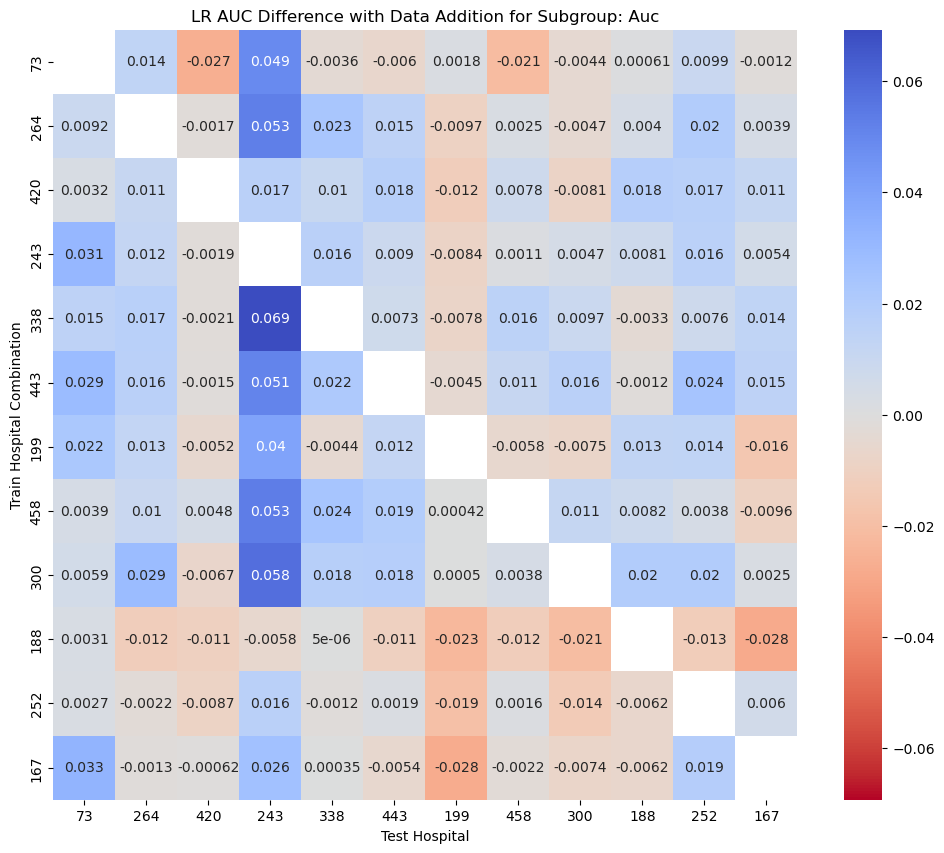

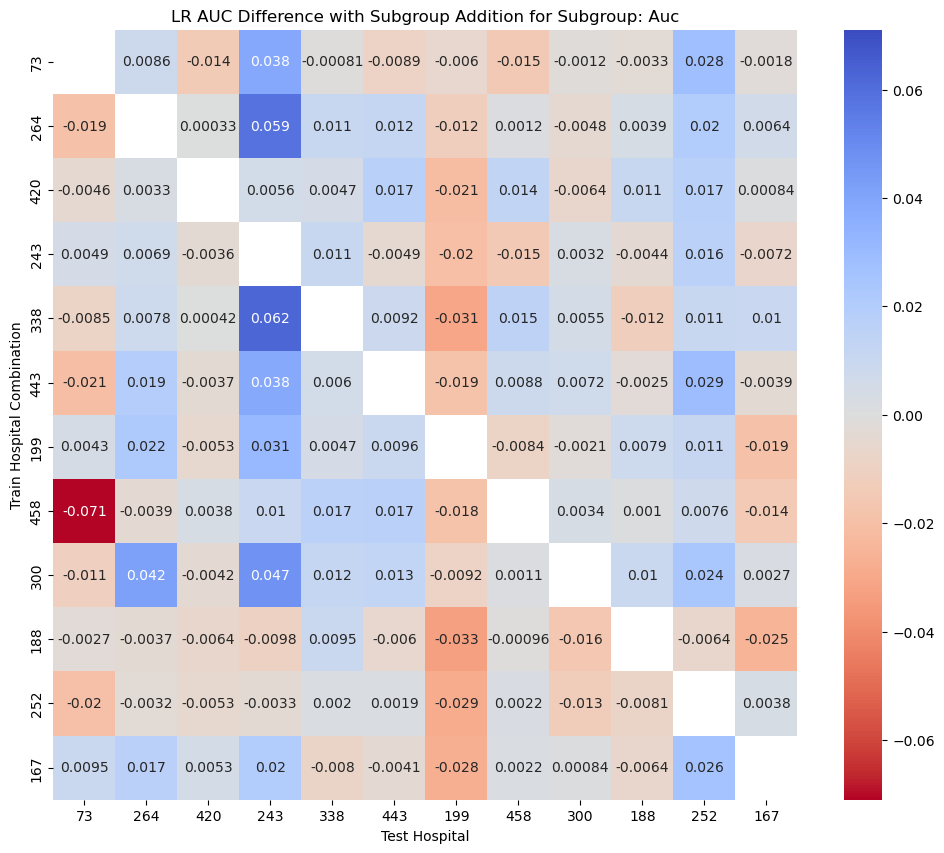

In [13]:
def plot_data_addition_auc(subgroup, subgroup_only=False):
    if subgroup_only:
        subgroup_data = add_data_avg[subgroup]
    else:
        subgroup_data = add_subgroup_avg[subgroup]
        
    subgroup_data = np.where(subgroup_data == 0, np.nan, subgroup_data)
    
    plt.figure(figsize=(12, 10))
    
    min_val = np.nanmin(subgroup_data)
    max_val = np.nanmax(subgroup_data)
    limit = max(abs(min_val), abs(max_val))

    sns.heatmap(subgroup_data, annot=True, cmap='coolwarm_r', 
                xticklabels=hospital_ids, yticklabels=hospital_ids)

    try:
        plt.title(f"LR AUC with Data Addition for Subgroup: {map_attribute[subgroup.split('_')[0]].title()}")
    except:
        plt.title(f"LR AUC with Data Addition for Subgroup: {subgroup.title()}")
    plt.xlabel("Test Hospital")
    plt.ylabel("Train Hospital Combination")
    plt.show()


def plot_data_addition_auc_diff(subgroup, subgroup_only=False):
    if subgroup_only:
        data = subgroup_addition_data
    else:
        data = addition_data
    
    np.fill_diagonal(data[subgroup], np.nan)
    
    plt.figure(figsize=(12, 10))
    
    min_val = np.nanmin(data[subgroup])
    max_val = np.nanmax(data[subgroup])
    limit = max(abs(min_val), abs(max_val))

    sns.heatmap(data[subgroup], annot=True, cmap='coolwarm_r', 
                xticklabels=hospital_ids, yticklabels=hospital_ids, 
                vmin=-limit, vmax=limit, center=0)

    if subgroup_only:
        plt.title(f"LR AUC Difference with Subgroup Addition for Subgroup: {subgroup.title()}")
    else:
        plt.title(f"LR AUC Difference with Data Addition for Subgroup: {subgroup.title()}")
    plt.xlabel("Test Hospital")
    plt.ylabel("Train Hospital Combination")
    plt.show()


plot_data_addition_auc_diff('AUC')
plot_data_addition_auc_diff('AUC', subgroup_only=True)

# for subgroup in addition_data.keys():
#     plot_data_addition_auc_diff(subgroup)

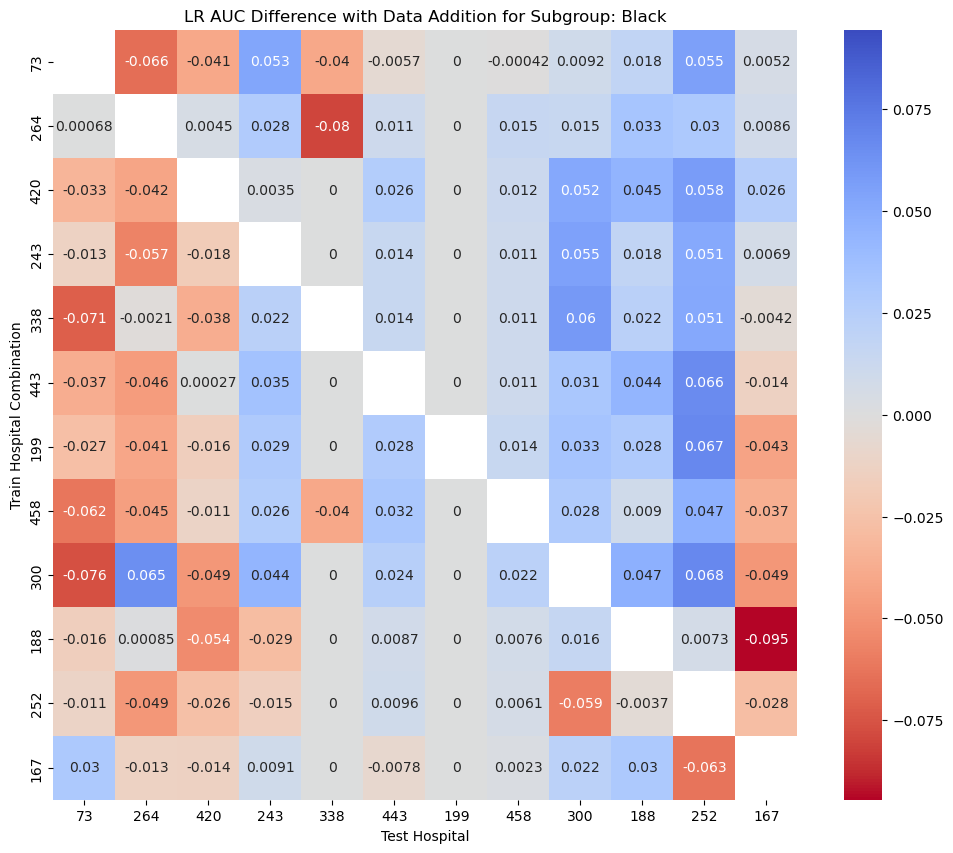

In [19]:
plot_data_addition_auc_diff('black')

## Data Addition Heuristics to Improve Subgroup Accuracy

In [20]:
# parameters
subgroup = "white"

exp = "count"
row = f"{subgroup}_{exp}"

file = f"{list(map_attribute.keys())[list(map_attribute.values()).index(subgroup)]}_AUC_TEST"

In [21]:
df_race = df_race[df_race[f"{subgroup}_rate"] > 0.1]
hospital_ids = df_race["hosp_id"].to_list()

In [22]:
df_race

,hosp_id,count,AUC,white_count,black_count,other_count,asian_count,white_rate,black_rate,other_rate,asian_rate,white_auc,black_auc,other_auc,asian_auc,worst_race_subgroup
0,73,4320,0.7609,3221,622,347,61,0.7577,0.1463,0.0816,0.0143,0.7085,0.8535,0.8824,1.0000,white
11,167,2107,0.7611,1503,154,421,29,0.7133,0.0731,0.1998,0.0138,0.7487,0.7655,0.8089,0.8214,white
9,188,2299,0.8015,1689,517,64,29,0.7347,0.2249,0.0278,0.0126,0.7976,0.8279,0.8108,0.9438,white
6,199,2529,0.8489,2434,42,48,3,0.9632,0.0166,0.0190,0.0012,0.8454,1.0000,0.8646,0.0000,asian
3,243,2812,0.7453,1831,873,83,24,0.6514,0.3106,0.0295,0.0085,0.7113,0.7899,0.9692,0.0000,asian
10,252,2210,0.7196,1993,152,50,7,0.9051,0.0690,0.0227,0.0032,0.7142,0.7222,0.8691,0.9000,white
1,264,3745,0.7266,3299,263,64,31,0.9021,0.0719,0.0175,0.0085,0.7268,0.6336,0.9535,1.0000,black
8,300,2370,0.8258,2000,267,84,19,0.8439,0.1127,0.0354,0.0080,0.8245,0.7931,0.8803,1.0000,black
4,338,2762,0.7578,2568,41,143,5,0.9314,0.0149,0.0519,0.0018,0.7693,1.0000,0.5815,0.0000,asian
2,420,3425,0.7840,2940,157,276,52,0.8584,0.0458,0.0806,0.0152,0.7694,0.9650,0.8559,0.9457,white


In [23]:
def get_hospital_id_for_stat(df, column, stat):
    if stat == 'min':
        return df.loc[df[column] == df[column].min(), 'hosp_id'].values[0]
    elif stat == 'max':
        return df.loc[df[column] == df[column].max(), 'hosp_id'].values[0]
    elif stat == 'median':
        median_value = df[column].median()
        return df.loc[np.abs(df[column] - median_value).idxmin(), 'hosp_id']
    
def get_race_summary_df(subgroup):
    '''
    return dataframe with the hospital id of the min, max, and median metric value for specified columns:
    - AUC, {subgroup}_auc, {subgroup}_count, {subgroup}_rate, count
    '''

    df_subgroup = df_race[df_race.columns[df_race.columns.str.startswith(subgroup) | df_race.columns.isin(base_columns)]]

    # List of columns to summarize (excluding 'hospital_id')
    columns_to_summarize = df_subgroup.columns.difference(['hosp_id'])

    # Create an empty dataframe to store the results
    summary_df = pd.DataFrame(index=columns_to_summarize, columns=['min_hospital', 'max_hospital', 'median_hospital'])

    # Loop through each column and calculate the hospital_id for min, max, and median
    for column in columns_to_summarize:
        summary_df.loc[column, 'min_hospital'] = get_hospital_id_for_stat(df_subgroup, column, 'min')
        summary_df.loc[column, 'max_hospital'] = get_hospital_id_for_stat(df_subgroup, column, 'max')
        summary_df.loc[column, 'median_hospital'] = get_hospital_id_for_stat(df_subgroup, column, 'median')

    return summary_df

def get_race_result_df(subgroup):
    summary_df = get_race_summary_df(subgroup)
    
    results = []

    # Iterate over each hospital_id
    for hospital_id in hospital_ids:
        # Get the hospital_ids for min, max, and median from summary_df for the specified row
        min_hospital = summary_df.loc[row, 'min_hospital']
        max_hospital = summary_df.loc[row, 'max_hospital']
        median_hospital = summary_df.loc[row, 'median_hospital']
        
        # Extract the corresponding values from add_data_avg
        auc_add_min = add_data_avg[file][hospital_dict[min_hospital], hospital_dict[hospital_id]]
        auc_add_max = add_data_avg[file][hospital_dict[max_hospital], hospital_dict[hospital_id]]
        auc_add_median = add_data_avg[file][hospital_dict[median_hospital], hospital_dict[hospital_id]]
        
        # Append the result row as a dictionary
        results.append({
            'hospital_id': hospital_id,
            'auc_add_min': auc_add_min,
            'auc_add_max': auc_add_max,
            'auc_add_median': auc_add_median,
            'auc_base': hospital_data[hospital_id]['AUC']
        })

    # Convert the result list into a dataframe
    result_df = pd.DataFrame(results)

    # Display the resulting dataframe
    return result_df

get_race_result_df(subgroup)

,hospital_id,auc_add_min,auc_add_max,auc_add_median,auc_base
0,73,0.769486,0.733874,0.722818,0.760851
1,167,0.764229,0.744831,0.756297,0.761059
2,188,0.786398,0.796324,0.795093,0.801487
3,199,0.840624,0.837825,0.828027,0.848880
4,243,0.749499,0.767532,0.749923,0.745265
5,252,0.736992,0.734352,0.000000,0.719608
6,264,0.746094,0.000000,0.726247,0.726608
7,300,0.846137,0.821600,0.821370,0.825807
8,338,0.790961,0.796734,0.763229,0.757790
9,420,0.767483,0.765557,0.760094,0.784005


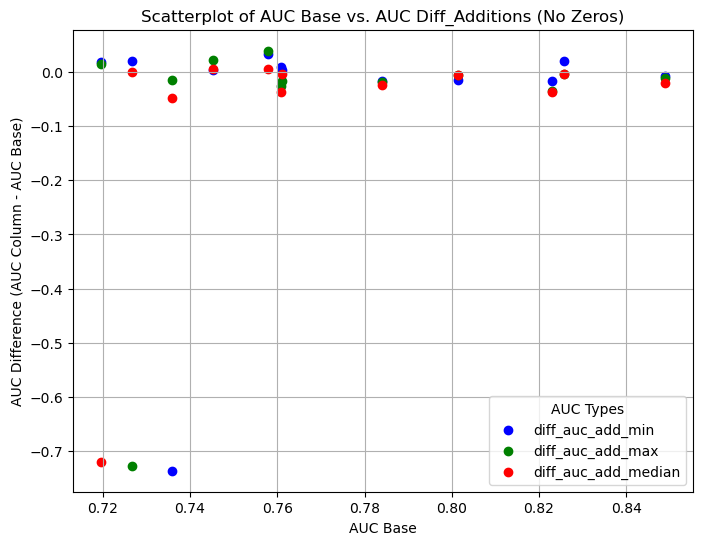

Correlation between auc_base and diff_auc_add_min: 0.2462
Average diff_auc_add_min: -0.0572
Correlation between auc_base and diff_auc_add_max: 0.3133
Average diff_auc_add_max: -0.0653
Correlation between auc_base and diff_auc_add_median: 0.3955
Average diff_auc_add_median: -0.0745


In [24]:
def plot_add_aucs(result_df, diff=False):
    # Handle AUC differences or values
    suffix = 'diff_' if diff else ''
    if diff:
        result_df[f'diff_auc_add_min'] = result_df['auc_add_min'] - result_df['auc_base']
        result_df[f'diff_auc_add_max'] = result_df['auc_add_max'] - result_df['auc_base']
        result_df[f'diff_auc_add_median'] = result_df['auc_add_median'] - result_df['auc_base']
    
    value_vars = [f'{suffix}auc_add_min', f'{suffix}auc_add_max', f'{suffix}auc_add_median']
    result_df_filtered = result_df[(result_df['auc_base'] != 0) & result_df[value_vars].ne(0).all(axis=1)]
    
    # Melt the dataframe to long format for plotting
    melted_df = result_df_filtered.melt(id_vars='auc_base', value_vars=value_vars, 
                                        var_name='AUC_Type', value_name=f'AUC_{suffix.capitalize()}Value')
    
    # Plot scatterplot
    plt.figure(figsize=(8, 6))
    colors = {f'{suffix}auc_add_min': 'blue', f'{suffix}auc_add_max': 'green', f'{suffix}auc_add_median': 'red'}
    for auc_type in melted_df['AUC_Type'].unique():
        subset = melted_df[melted_df['AUC_Type'] == auc_type]
        plt.scatter(subset['auc_base'], subset[f'AUC_{suffix.capitalize()}Value'], label=auc_type, color=colors[auc_type])
    
    # Add labels, title, and show plot
    plt.xlabel('AUC Base')
    plt.ylabel(f'AUC {suffix.capitalize()}Value' if not diff else f'AUC Difference (AUC Column - AUC Base)')
    plt.title(f'Scatterplot of AUC Base vs. AUC {suffix.capitalize()}Additions (No Zeros)')
    plt.legend(title='AUC Types')
    plt.grid(True)
    plt.show()

    # Calculate and print correlations
    for auc_type in value_vars:
        correlation = result_df_filtered['auc_base'].corr(result_df_filtered[auc_type])
        print(f"Correlation between auc_base and {auc_type}: {correlation:.4f}")
        print(f"Average {auc_type}: {result_df[auc_type].mean():.4f}")

plot_add_aucs(get_race_result_df(subgroup), diff=True)

In [32]:
def plot_add_auc_by_subgroup_metric(subgroup, exp, diff=False, x_change=False):
    file = f"{list(map_attribute.keys())[list(map_attribute.values()).index(subgroup)]}_AUC_TEST"
    
    add_data_dict = {}
    for test_hosp_id in hospital_ids:
        test_hosp_points = []
        for train_hosp_id in hospital_ids:
            train_hosp_metric = df_race.loc[df_race['hosp_id'] == train_hosp_id][f"{subgroup}_{exp}"].values[0] #rate of train hosp
            
            if x_change and exp == 'rate':
                test_hosp_metric = df_race.loc[df_race['hosp_id'] == test_hosp_id][f"{subgroup}_{exp}"].values[0]
                train_hosp_cnt = df_race.loc[df_race['hosp_id'] == train_hosp_id]["count"].values[0]
                test_hosp_cnt = df_race.loc[df_race['hosp_id'] == test_hosp_id]["count"].values[0]
                
                train_hosp_metric = np.average([train_hosp_metric, test_hosp_metric], weights=[train_hosp_cnt, test_hosp_cnt]) - test_hosp_metric
                
            add_data_auc = add_data_avg[file][hospital_dict[train_hosp_id], hospital_dict[test_hosp_id]]
            add_data_auc_std = add_data_std[file][hospital_dict[train_hosp_id], hospital_dict[test_hosp_id]]
            add_data_auc_ci_lower = add_data_ci[file][0][hospital_dict[train_hosp_id], hospital_dict[test_hosp_id]]
            add_data_auc_ci_upper = add_data_ci[file][1][hospital_dict[train_hosp_id], hospital_dict[test_hosp_id]]
            
            test_hosp_points.append((train_hosp_metric, add_data_auc))
        add_data_dict[test_hosp_id] = test_hosp_points

    colors = plt.cm.get_cmap('tab10', len(add_data_dict))

    # Initialize a figure for plotting
    plt.figure(figsize=(10, 8))

    # Dictionary to store correlation coefficients
    correlation_coeffs = {}

    # Iterate through the dictionary to plot each set of points and compute correlation
    for i, (key, value) in enumerate(add_data_dict.items()):
        
        if diff:
            filtered_values = [(x, y - dist_shift_avg[file][hospital_dict[key], hospital_dict[key]]) for (x, y) in value if x != 0 and y != 0]
        else:
            filtered_values = [(x, y) for (x, y) in value if x != 0 and y != 0]
        
        # If no valid data points remain, skip this key
        if len(filtered_values) == 0:
            continue
        
        # Extract x and y from the tuples
        x, y = zip(*filtered_values)
        
        # Compute correlation coefficient
        correlation_coeff = np.corrcoef(x, y)[0, 1]
        
        if not np.isnan(correlation_coeff):
            correlation_coeffs[key] = correlation_coeff
        
        # Plot the scatterplot for this key with a unique color
        plt.scatter(x, y, color=colors(i), label=f"{key} (corr={correlation_coeff:.2f})")

    # Add legend, labels
    plt.legend()
    plt.xlabel(f'{exp} of added hospital')
    plt.ylabel(f'{file}')
    plt.title(f'{subgroup}-{exp}')
    plt.grid(True)

    # Calculate and display average correlation coefficient on the plot
    avg_correlation_coeff = np.mean(list(correlation_coeffs.values()))
    plt.text(0.5, 0.05, f'Avg Corr: {avg_correlation_coeff:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

    # Show the plot
    plt.show()
    
    print(f"Average correlation coefficient: {avg_correlation_coeff:.2f}")


/tmp/ipykernel_1519723/3072288806.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(add_data_dict))


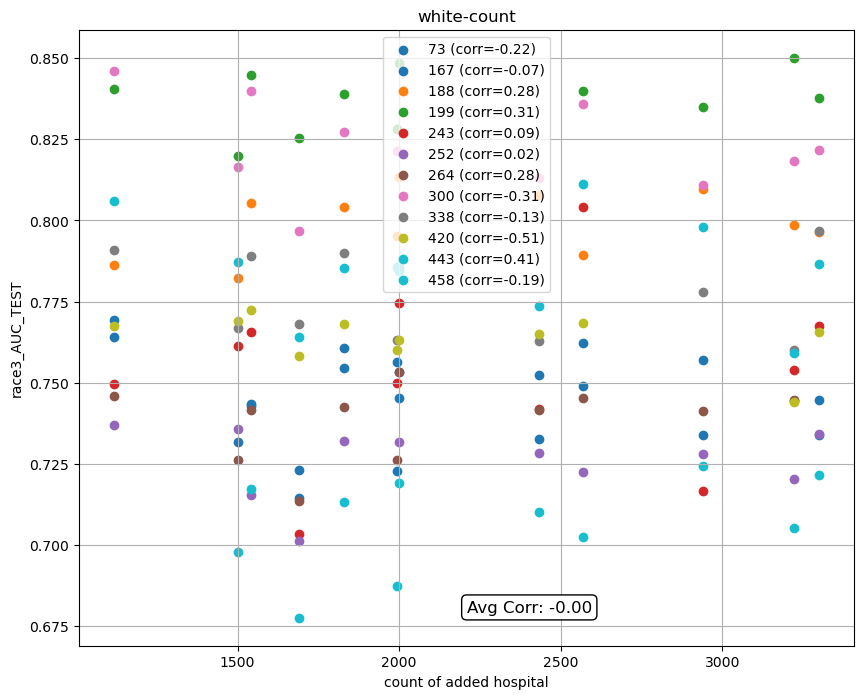

Average correlation coefficient: -0.00


In [33]:
plot_add_auc_by_subgroup_metric(subgroup, exp, diff=False, x_change=False)

In [27]:
# for subgroup in ["asian", "black", "other", "white"]:
#     for exp in ["rate", "count", "auc"]:
#         for diff in [False, True]:
#             for x_change in [False, True]:
#                 plot_add_auc_by_subgroup_metric(subgroup, exp, diff=diff, x_change=x_change)

In [34]:
def plot_add_auc_by_subgroup_metric(subgroup, exp, diff=False, x_change=False):
    file = f"{list(map_attribute.keys())[list(map_attribute.values()).index(subgroup)]}_AUC_TEST"
    
    add_data_dict = {}
    for test_hosp_id in hospital_ids:
        test_hosp_points = []
        for train_hosp_id in hospital_ids:
            train_hosp_metric = df_race.loc[df_race['hosp_id'] == train_hosp_id][f"{subgroup}_{exp}"].values[0]
            
            if x_change and exp == 'rate':
                test_hosp_metric = df_race.loc[df_race['hosp_id'] == test_hosp_id][f"{subgroup}_{exp}"].values[0]
                train_hosp_cnt = df_race.loc[df_race['hosp_id'] == train_hosp_id]["count"].values[0]
                test_hosp_cnt = df_race.loc[df_race['hosp_id'] == test_hosp_id]["count"].values[0]
                
                train_hosp_metric = np.average([train_hosp_metric, test_hosp_metric], weights=[train_hosp_cnt, test_hosp_cnt]) - test_hosp_metric
                
            add_data_auc = add_data_avg[file][hospital_dict[train_hosp_id], hospital_dict[test_hosp_id]]
            add_data_auc_std = add_data_std[file][hospital_dict[train_hosp_id], hospital_dict[test_hosp_id]]
            add_data_auc_ci_lower = add_data_ci[file][0][hospital_dict[train_hosp_id], hospital_dict[test_hosp_id]]
            add_data_auc_ci_upper = add_data_ci[file][1][hospital_dict[train_hosp_id], hospital_dict[test_hosp_id]]
            
            test_hosp_points.append((train_hosp_metric, add_data_auc, add_data_auc_std, add_data_auc_ci_lower, add_data_auc_ci_upper))
        add_data_dict[test_hosp_id] = test_hosp_points

    colors = plt.cm.get_cmap('tab10', len(add_data_dict))

    # Initialize a figure for plotting
    plt.figure(figsize=(10, 8))

    # Dictionary to store correlation coefficients
    correlation_coeffs = {}

    # Iterate through the dictionary to plot each set of points and compute correlation
    for i, (key, value) in enumerate(add_data_dict.items()):
        
        if diff:
            filtered_values = [(x, y - dist_shift_avg[file][hospital_dict[key], hospital_dict[key]], std, ci_lower, ci_upper) 
                               for (x, y, std, ci_lower, ci_upper) in value if x != 0 and y != 0]
        else:
            filtered_values = [(x, y, std, ci_lower, ci_upper) 
                               for (x, y, std, ci_lower, ci_upper) in value if x != 0 and y != 0]
        
        # If no valid data points remain, skip this key
        if len(filtered_values) == 0:
            continue
        
        # Extract x, y, std, and CI values
        x, y, y_std, y_ci_lower, y_ci_upper = zip(*filtered_values)
        
        # Compute correlation coefficient
        correlation_coeff = np.corrcoef(x, y)[0, 1]
        
        if not np.isnan(correlation_coeff):
            correlation_coeffs[key] = correlation_coeff
        
        # Plot the scatterplot for this key with a unique color, adding error bars for std and CI
        plt.errorbar(x, y, yerr=y_std, fmt='o', color=colors(i), label=f"{key} (corr={correlation_coeff:.2f})", 
                     ecolor=colors(i), elinewidth=1, capsize=3)
        
        # Add CI as a shaded region
        #plt.fill_between(x, y_ci_lower, y_ci_upper, color=colors(i), alpha=0.2)

    # Add legend, labels
    plt.legend()
    plt.xlabel(f'{exp} of added hospital')
    plt.ylabel(f'{file}')
    plt.title(f'{subgroup}-{exp}')
    plt.grid(True)

    # Calculate and display average correlation coefficient on the plot
    avg_correlation_coeff = np.mean(list(correlation_coeffs.values()))
    plt.text(0.5, 0.05, f'Avg Corr: {avg_correlation_coeff:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

    # Show the plot
    plt.show()
    
    print(f"Average correlation coefficient: {avg_correlation_coeff:.2f}")


/tmp/ipykernel_1519723/3571442463.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(add_data_dict))


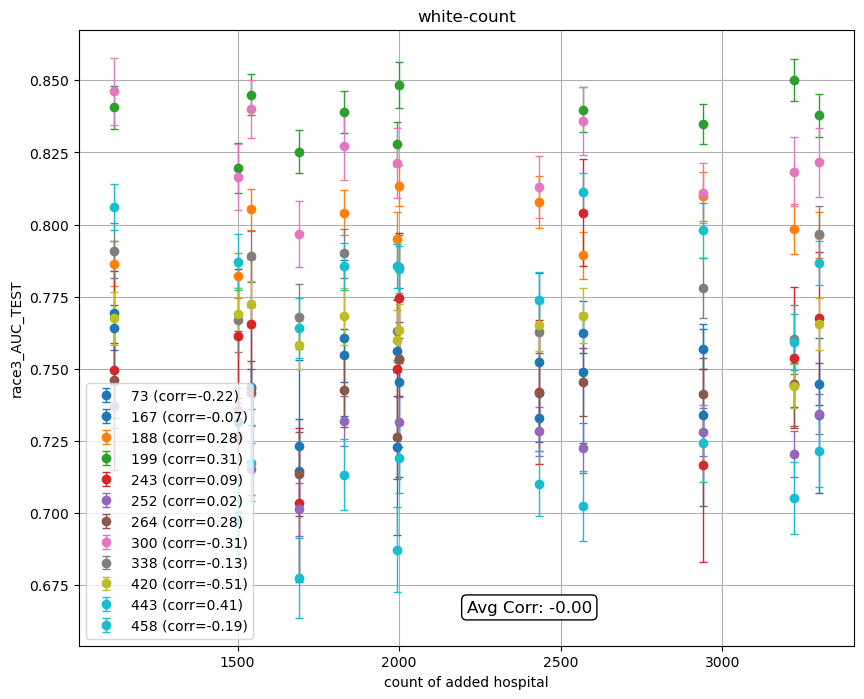

Average correlation coefficient: -0.00


In [35]:
plot_add_auc_by_subgroup_metric(subgroup, exp, diff=False, x_change=False)